In [79]:
import numpy as np
from numpy import genfromtxt
import scipy.io 
from scipy import stats
import matplotlib.pyplot as plt
import random
import pandas as pd
import pydot
from scipy.stats import hmean
from scipy.spatial.distance import cdist
import numbers
from collections import Counter,defaultdict

features = ['pclass','age','sibsp','parch','fare','sex','embarked_C','embarked_Q','embarked_S']
class_names = ['died','survived']

class DecisionTree:
    
    class Node:
        def __init__(self, split_rule, left, right, label, is_leaf):
            self.split_rule = split_rule
            self.left = left
            self.right = right
            self.label = label
            self.is_leaf = is_leaf # 1 = stop 
            
        def __repr__(self):
            """
            TODO: one way to visualize the decision tree is to write out a __repr__ method
            that returns the string representation of a tree. Think about how to visualize
            a tree structure. You might have seen this before in CS61A.
            """
            def viz(Node, prefix, symbol):
                if not Node:
                    return prefix + '[]'
                if Node.is_leaf == 1:
                    return(prefix + '(Therefore the person was: '+ class_names[Node.label] + ')')
                else:
                    ret = (prefix + '[Feature: '+ str(Node.split_rule[0]) + 
                           ', Threshold: '+symbol+ str(Node.split_rule[1]) + ']')
                    ret += '\n' + viz(Node.left, prefix + '\t','<=') + '\n' + viz(Node.right, prefix + '\t','>')
                    return ret
                
            return viz(self, "",'<=')
    
        
    def __init__(self, max_depth = 200):
        self.max_depth = max_depth
        
    def max_count(self, array):
        return stats.mode(array, nan_policy='omit')[0][0]
    
    def entropy(self,y):
        p = y / (np.sum(y)+1e-10)
        return -p.dot(np.log2(p+1e-10))
    
    def entropy_impurity(self,left_y_freq, right_y_freq):
        Sl = np.sum(left_y_freq)
        Sr = np.sum(right_y_freq)
        return (Sl * self.entropy(left_y_freq) + Sr * self.entropy(right_y_freq)) / (Sl+Sr)
    
    def information_gain(self,left_y_freq, right_y_freq):
        total = left_y_freq + right_y_freq
        if self.entropy(total) == 0: # see if it is pure
            return -1
        else:
            infor_gain = self.entropy(total) - self.entropy_impurity(left_y_freq, right_y_freq)
        return infor_gain
    
#     @staticmethod
#     def gini(y): 
#         p = y / (np.sum(y)+1e-20)
#         gini = 1-np.sum(p**2)
#         return gini

#     @staticmethod
#     def gini_impurity(left_label_freq, right_label_freq): # useless
#         Sl = np.sum(left_label_freq)
#         Sr = np.sum(right_label_freq)
#         return (Sl * gini(left_label_freq) + Sr * gini(right_label_freq)) / (Sl+Sr)

#     @staticmethod 
#     def gini_purification(X, y, thresh):
#         """
#         TODO: implement a method that calculates reduction in impurity gain given a vector of features
#         and a split threshold
#         """
#         return 0
    
    def split(self, S, depth, random_f = -1, verbose = False): # recursively
        """
        TODO: implement a method that return a split of the dataset given an index of the feature and
        a threshold for it
        """
#         print((depth-1) * '    '+'Depth: '+ str(depth))
        if depth >= self.max_depth: 
#             print('label: '+ str(self.max_count(self.labels[S])))
            node = self.Node(left=None, right=None, split_rule=None, is_leaf=1, label=self.max_count(self.labels[S]))
            if verbose == True:
                print(repr(node))
            return node
        else:
            max_feature, max_thresh = self.segmenter(self.data[S, :], self.labels[S],random_f = random_f)
            
#             print((depth-1) * '    '+'depth:' + str(depth)  + ', feature index: ' + str(max_feature) +', threshold: ' + str(max_thresh))
            Sl = [i for i in S if self.data[i, max_feature] <= max_thresh]
            Sr = [i for i in S if self.data[i, max_feature] > max_thresh]
#             print((depth-1) * '    '+"left group: " + str(len(Sl)) + ', right group: ' + str(len(Sr)))
            if len(Sl) <= 5 or len(Sr) <= 5: 
#                 print('label: '+ str(self.max_count(self.labels[S])))
                node = self.Node(left=None, right=None, split_rule=None, is_leaf=1, label=self.max_count(self.labels[S]))
                if verbose == True:
                    print(repr(node))
                return node
            else:
                node = self.Node(left=self.split(Sl, depth+1, random_f), right=self.split(Sr,depth+1,random_f), split_rule = (max_feature, max_thresh), is_leaf=0, label=None)
                if verbose == True:
                    print(repr(node))
                return node
    
    
    def iter_thresh(self, X, y):
        row_f = sorted(set(X)) 
        col_l = set(y)
        freq_matrix = np.zeros([len(row_f), len(col_l)])
        for i, j in enumerate(row_f):
            for k, l in enumerate(col_l):
                freq_matrix[i, k] = len(y[np.where(y[np.where(X==j)]==l)])
        all_thresh = np.array(row_f[1:] + row_f[-1:]) / 2.
        left_freq = np.zeros([len(col_l)])
        right_freq = np.sum(freq_matrix, axis=0)
        left_freq_sum = 0
        max_thresh = all_thresh[0]
        
        max_gain = self.information_gain(left_freq, right_freq)
        for i, thresh in enumerate(all_thresh):
            left_freq += freq_matrix[i, :]
            right_freq -= freq_matrix[i, :]
            gain = self.information_gain(left_freq, right_freq)
            if gain > max_gain:
                max_gain = gain
                max_thresh = thresh
        return max_thresh, max_gain
    
    
    def segmenter(self, X, y, random_f = -1):
        """
        TODO: compute entropy gain for all single-dimension splits,
        return the feature and the threshold for the split that
        has maximum gain
        """        
        x = X.shape[1]
        if random_f == -1:
            all_features = np.arange(x)
        else:
            all_features = np.random.choice(range(x), random_f)
            
        all_features = np.arange(x)
        max_gain = 1e-10
        max_thresh = 0
        max_feature = 0
        for i in all_features:
            thresh, gain = self.iter_thresh(X[:, i], y)
            if gain > max_gain:
                max_gain = gain
                max_thresh = thresh
                max_feature = i
        return max_feature, max_thresh
    
    
    def fit(self, X, y, random_f = -1, verbose = False):
        """
        TODO: fit the model to a training set. Think about what would be 
        your stopping criteria
        """
        self.data = X
        self.labels = y
        S = np.array(range(len(y)))
        self.root = self.split(S, 1 , random_f = random_f,verbose = verbose)

        return self

    
    def predict(self, X, T = 0):
        """
        TODO: predict the labels for input data 
        """
        if T == 1: # T = 1 for random forest
            X = np.reshape(X, [1, len(X)])
            row_num = 1
        else:
            row_num = X.shape[0]
        labels = np.zeros(row_num)    
        depth = 0    
        for i in range(row_num): 
            current_node = self.root
            while current_node.is_leaf == 0: 
                feature = current_node.split_rule[0]
                thresh = current_node.split_rule[1]
                if X[i,:][feature] <= thresh:
                    current_node = current_node.left
                else:
                    current_node = current_node.right
            depth += 1
            labels[i] = current_node.label
        return labels
    
    def accuracy(self, X, y_val, T = 0):
        y_pred = self.predict(X, T = T)
        len_y = float(len(y_pred))
        return np.sum(y_pred == y_val) / len_y
    

class RandomForest():
    
    def __init__(self, n_trees=20, n_sample=1000, random_f=-1, max_depth=200):
        """
        TODO: initialization of a random forest
        """
        self.n_trees = n_trees
        self.n_sample = n_sample
        self.random_f = random_f
        self.max_depth = max_depth
        self.trees = np.array([DecisionTree(max_depth)] * n_trees)
        
    def fit(self, X, y, verbose = False):
        """
        TODO: fit the model to a training set.
        """
        if self.random_f == -1:
            self.random_f = int(np.sqrt(X.shape[1])) 
        results = np.zeros(self.n_trees, dtype=object)
        for i, dt in enumerate(self.trees):
            print('#%d. tree' % (i+1))
            idx = np.random.choice(range(len(X)), self.n_sample)
            sub_X = X[idx, :]
            sub_y = y[idx]
            results[i] = dt.fit(sub_X, sub_y, random_f=self.random_f, verbose = verbose)
        self.trees = results
        
    def predict(self, X, T = 1):
        """
        TODO: predict the labels for input data 
        """
        row_num = X.shape[0]
        labels = []    
        for i in range(row_num):
            pred = np.zeros(self.n_trees)
            for j, dt in enumerate(self.trees):
                pred[j] = dt.predict(X[i, :], T = T)
            labels.append(dt.max_count(pred))
        return labels
    
    def accuracy(self, X, y_val, T = 1):
        y_pred = self.predict(X,T = T)
        N = float(len(y_pred))
        return np.sum(y_pred == y_val) / N




In [97]:
# Load titanic data 
titanic_train = pd.read_csv('datasets/titanic/titanic_training.csv')
titanic_test = pd.read_csv('datasets/titanic/titanic_testing_data.csv')

# remove ticket and cabin column
titanic_train.drop(['ticket', 'cabin'], inplace=True, axis=1)
titanic_test.drop(['ticket', 'cabin'], inplace=True, axis=1)


In [100]:
# Load titanic data 
titanic_train = pd.read_csv('datasets/titanic/titanic_training.csv')
titanic_test = pd.read_csv('datasets/titanic/titanic_testing_data.csv')

# remove ticket and cabin column
titanic_train.drop(['ticket', 'cabin'], inplace=True, axis=1)
titanic_test.drop(['ticket', 'cabin'], inplace=True, axis=1)

# fillna
titanic_train["survived"].fillna(titanic_train["survived"].mode(), inplace=True)
for data in [titanic_train, titanic_test]:
    data["fare"].fillna(data["fare"].median(), inplace=True)
    data["embarked"].fillna(data["embarked"].mode(), inplace=True)
    data["parch"].fillna(data["parch"].median(), inplace=True)
    data["sibsp"].fillna(data["sibsp"].median(), inplace=True)
#     data["age"].fillna(data["age"].median(), inplace=True)
    data["sex"].fillna(data["sex"].mode(), inplace=True)
    data["pclass"].fillna(data["pclass"].median(), inplace=True)

In [82]:
# feature engineering

In [102]:
titanic_train['family_size'] = titanic_train['sibsp'] + titanic_train['parch']
titanic_test['family_size'] = titanic_test['sibsp'] + titanic_test['parch']

In [85]:
# t_label_enc['survived'].fillna(t_label_enc['survived'].mode(),inplace = True)

In [103]:
titanic_train['family'] = ''
titanic_train.loc[titanic_train['family_size'] == 0, 'family'] = 0
titanic_train.loc[(titanic_train['family_size'] > 0) & (titanic_train['family_size'] <= 3), 'family'] = 1
titanic_train.loc[(titanic_train['family_size'] > 3) & (titanic_train['family_size'] <= 6), 'family'] = 2
titanic_train.loc[titanic_train['family_size'] > 6, 'family'] = 3

titanic_test['family'] = ''
titanic_test.loc[titanic_test['family_size'] == 0, 'family'] = 0
titanic_test.loc[(titanic_test['family_size'] > 0) & (titanic_test['family_size'] <= 3), 'family'] = 1
titanic_test.loc[(titanic_test['family_size'] > 3) & (titanic_test['family_size'] <= 6), 'family'] = 2
titanic_test.loc[titanic_test['family_size'] > 6, 'family'] = 3

In [104]:
titanic_train['ageRange'] = pd.cut(titanic_train['age'], bins=[0,15,35,45,60,200], labels=['<15','15-35','35-45','40-60','>60'], include_lowest=True)
titanic_train['fareRange'] = pd.cut(titanic_train['fare'], bins=[0,10,30,60,1000], labels=['<10','10-30','30-60','>60'], include_lowest=True)
titanic_test['ageRange'] = pd.cut(titanic_test['age'], bins=[0,15,35,45,60,200], labels=['<15','15-35','35-45','40-60','>60'], include_lowest=True)
titanic_test['fareRange'] = pd.cut(titanic_test['fare'], bins=[0,10,30,60,1000], labels=['<10','10-30','30-60','>60'], include_lowest=True)

In [88]:
new = titanic_train[['ageRange','family']].groupby(titanic_train['ageRange']).mean()
new
# plt.plot(titanic_train['ageRange'],titanic_train['family_size'])

,family
ageRange,
<15,1.325000
15-35,0.376321
35-45,0.593750
40-60,0.537634
>60,0.433333


In [31]:
titanic_train.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,family_size,family,ageRange,fareRange
0,0.0,3.0,male,NaN,0.0,0.0,8.0500,S,0.0,0,NaN,<10
1,0.0,1.0,male,22.0,0.0,0.0,135.6333,C,0.0,0,15-35,>60
2,0.0,2.0,male,23.0,0.0,0.0,15.0458,C,0.0,0,15-35,10-30
3,0.0,2.0,male,42.0,0.0,0.0,13.0000,S,0.0,0,35-45,10-30
4,0.0,3.0,male,20.0,0.0,0.0,9.8458,S,0.0,0,15-35,<10


In [35]:
titanic_train['family'].unique()

array([0, 1, 2, 3], dtype=int64)

In [108]:
sub_zero = titanic_train[titanic_train['family'] == 0]
sub_one = titanic_train[titanic_train['family'] == 1]
sub_two = titanic_train[titanic_train['family'] == 2]
sub_three = titanic_train[titanic_train['family'] == 3]

In [109]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
sub_zero_fill = imp.fit_transform(sub_zero[['age','family']])
sub_one_fill = imp.fit_transform(sub_one[['age','family']])
sub_two_fill = imp.fit_transform(sub_two[['age','family']])
sub_three_fill = imp.fit_transform(sub_three[['age','family']])

new = np.vstack((sub_zero_fill,sub_one_fill,sub_two_fill,sub_three_fill))
titanic_train['age_new'] = new[:,0]
titanic_train['family_new'] = new[:,1]
titanic_train.head()

C:\Users\dizhe\Anaconda3\envs\mcm\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,family_size,family,ageRange,fareRange,age_new,family_new
0,0.0,3.0,male,NaN,0.0,0.0,8.0500,S,0.0,0,NaN,<10,31.828375,0.0
1,0.0,1.0,male,22.0,0.0,0.0,135.6333,C,0.0,0,15-35,>60,22.000000,0.0
2,0.0,2.0,male,23.0,0.0,0.0,15.0458,C,0.0,0,15-35,10-30,23.000000,0.0
3,0.0,2.0,male,42.0,0.0,0.0,13.0000,S,0.0,0,35-45,10-30,42.000000,0.0
4,0.0,3.0,male,20.0,0.0,0.0,9.8458,S,0.0,0,15-35,<10,20.000000,0.0


In [175]:
sub_zero = titanic_test[titanic_test['family'] == 0]
sub_one = titanic_test[titanic_test['family'] == 1]
sub_two = titanic_test[titanic_test['family'] == 2]
sub_three = titanic_test[titanic_test['family'] == 3]

In [176]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
sub_zero_fill = imp.fit_transform(sub_zero[['age','family']])
sub_one_fill = imp.fit_transform(sub_one[['age','family']])
sub_two_fill = imp.fit_transform(sub_two[['age','family']])
sub_three_fill = imp.fit_transform(sub_three[['age','family']])

new = np.vstack((sub_zero_fill,sub_one_fill,sub_two_fill,sub_three_fill))
titanic_test['age_new'] = new[:,0]
titanic_test['family_new'] = new[:,1]
titanic_test.head()

C:\Users\dizhe\Anaconda3\envs\mcm\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


,pclass,sex,age,sibsp,parch,fare,embarked,family_size,family,ageRange,fareRange,age_new,family_new
0,1.0,female,24.0,0.0,0.0,69.3000,C,0.0,0,15-35,>60,24.0,0.0
1,1.0,female,44.0,0.0,1.0,57.9792,C,1.0,1,35-45,30-60,29.0,0.0
2,3.0,male,1.0,5.0,2.0,46.9000,S,7.0,3,<15,30-60,30.0,0.0
3,3.0,male,29.0,0.0,0.0,7.8750,S,0.0,0,15-35,<10,20.0,0.0
4,2.0,male,30.0,0.0,0.0,13.0000,S,0.0,0,15-35,10-30,25.0,0.0


In [177]:
titanic_train['ageRange'] = pd.cut(titanic_train['age'], bins=[0,15,35,45,60,200], labels=['<15','15-35','35-45','40-60','>60'], include_lowest=True)
titanic_train['fareRange'] = pd.cut(titanic_train['fare'], bins=[0,10,30,60,1000], labels=['<10','10-30','30-60','>60'], include_lowest=True)
titanic_test['ageRange'] = pd.cut(titanic_test['age'], bins=[0,15,35,45,60,200], labels=['<15','15-35','35-45','40-60','>60'], include_lowest=True)
titanic_test['fareRange'] = pd.cut(titanic_test['fare'], bins=[0,10,30,60,1000], labels=['<10','10-30','30-60','>60'], include_lowest=True)

In [178]:
# get dummy
t_train = titanic_train.copy()
dummy_col = ['pclass','sex','embarked','ageRange','fareRange']
for col in dummy_col:
    dummy = pd.get_dummies(t_train[col],drop_first=True)
    t_train = pd.concat([t_train,dummy], axis = 1)
t_train.head()

t_test = titanic_test.copy()
for col in dummy_col:
    dummy = pd.get_dummies(t_test[col],drop_first=True)
    t_test = pd.concat([t_test,dummy], axis = 1)    
t_test.head()

,pclass,sex,age,sibsp,parch,fare,embarked,family_size,family,ageRange,...,male,Q,S,15-35,35-45,40-60,>60,10-30,30-60,>60
0,1.0,female,24.0,0.0,0.0,69.3000,C,0.0,0,15-35,...,0,0,0,1,0,0,0,0,0,1
1,1.0,female,44.0,0.0,1.0,57.9792,C,1.0,1,35-45,...,0,0,0,0,1,0,0,0,1,0
2,3.0,male,1.0,5.0,2.0,46.9000,S,7.0,3,<15,...,1,0,1,0,0,0,0,0,1,0
3,3.0,male,29.0,0.0,0.0,7.8750,S,0.0,0,15-35,...,1,0,1,1,0,0,0,0,0,0
4,2.0,male,30.0,0.0,0.0,13.0000,S,0.0,0,15-35,...,1,0,1,1,0,0,0,1,0,0


In [183]:
t_test.columns

Index([   'age_new', 'family_new',          2.0,          3.0,       'male',
                'Q',          'S',      '15-35',      '35-45',      '40-60',
              '>60',      '10-30',      '30-60',        '>60'],
      dtype='object')

In [181]:
t_train.drop(['sex','age','sibsp','parch','fare','embarked','pclass','family_size','ageRange','fareRange','family'], inplace=True, axis=1)
t_test.drop(['sex','age','sibsp','parch','fare','embarked','pclass','family_size','ageRange','fareRange','family'], inplace=True, axis=1)

In [184]:
t_label_enc = t_train[['survived']]
t_train_enc = t_train.iloc[:,1:]
t_test_enc = t_test
t_train_enc.head()

,age_new,family_new,2.0,3.0,male,Q,S,15-35,35-45,40-60,>60,10-30,30-60,>60
0,31.828375,0.0,0,1,1,0,1,0,0,0,0,0,0,0
1,22.000000,0.0,0,0,1,0,0,1,0,0,0,0,0,1
2,23.000000,0.0,1,0,1,0,0,1,0,0,0,1,0,0
3,42.000000,0.0,1,0,1,0,1,0,1,0,0,1,0,0
4,20.000000,0.0,0,1,1,0,1,1,0,0,0,0,0,0


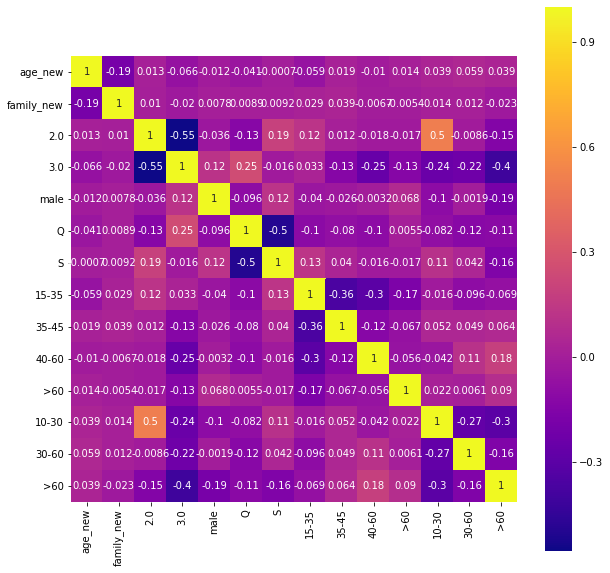

In [185]:
# check the correlation
import seaborn as sns
hotmap = plt.cm.plasma
plt.figure(figsize=(10,10))
sns.heatmap(t_train_enc.corr(),square=True, cmap=hotmap,annot = True)

In [108]:
# from sklearn.feature_selection import SelectKBest, chi2

# #Feature selection using SelectKBest
# test = SelectKBest(score_func=chi2, k=8)
# fit = test.fit(t_train_enc, t_label_enc)
# # summarize scores
# np.set_printoptions(precision=3)
# print(fit.scores_)
# features = fit.transform(t_train_enc)
# # summarize selected features
# print(features[0:5,:])
# print (t_train_enc.head())

In [186]:
t_label_enc.fillna(0,inplace = True)
t_label_enc.isnull().sum()

C:\Users\dizhe\Anaconda3\envs\mcm\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


survived    0
dtype: int64

In [187]:
t_label_enc.isnull().sum()

survived    0
dtype: int64

In [189]:
from sklearn.feature_selection import SelectKBest, chi2
best = SelectKBest(score_func=chi2, k=14)
fit = best.fit(t_train_enc,t_label_enc)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(pd.DataFrame(t_train_enc).columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
topindex = featureScores['Score'].sort_values(ascending = False)[:10].index
topindex = topindex.tolist()

train_X_selected = t_train_enc.iloc[:,topindex]
test_X_selected = t_test_enc.iloc[:,topindex]

In [196]:
t_train_sele = t_train_enc#[['age','fare',1.0,'female','male']]
t_test_sele = t_test_enc#[['age','fare',1.0,'female','male']]
t_train_sele = t_train_sele.values
t_test_sele = t_test_sele.values

In [197]:
# split data
idx = np.random.choice(range(len(t_label_enc)),len(t_label_enc),replace = False)
split = int(len(t_label_enc)*0.8)
t_train_sele[idx][:split,]
X_train,X_val = t_train_sele[idx][:split,],t_train_sele[idx][split:,]
y_train,y_val = np.array(t_label_enc)[idx][:split],np.array(t_label_enc)[idx][split:]

y_val = y_val.astype("int64")
y_val = y_val.flatten()
y_train = y_train.astype("int64")
y_train = y_train.flatten()

In [198]:
# try training
dt = DecisionTree(3)
dt.fit(X_train, y_train, verbose = True)
train_acc = dt.accuracy(X_train, y_train)
print('Training accuracy: ', train_acc)
val_acc = dt.accuracy(X_val, y_val)
print('Validation accuracy: ', val_acc)

[Feature: 4, Threshold: <=0.5]
	[Feature: 3, Threshold: <=0.5]
		(Therefore the person was: survived)
		(Therefore the person was: survived)
	[Feature: 3, Threshold: >0.5]
		(Therefore the person was: died)
		(Therefore the person was: died)
Training accuracy:  0.78375
Validation accuracy:  0.805


In [199]:
y_pred = dt.predict(t_test_sele)
y_pred = np.array(y_pred)

In [200]:
y_pred.shape

(310,)

In [201]:
# save
def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv('submission_titanic_rf_7.29.23.12.csv', index_label='Id')
    
results_to_csv(y_pred)